In [1]:
!apt-get install build-essential python3-dev python3-numpy libhdf4-dev -y
!pip install pyhdf
!pip install openturns
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import tables
import h5py
import numpy as np
import sys
from pyhdf.SD import SD, SDC
import pandas as pd
import time
import calendar
import matplotlib.pyplot as plt
import datetime
import os
import openturns as ot
import datetime
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/BadgerX Data"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
python3-dev is already the newest version (3.6.7-1~18.04).
The following additional packages will be installed:
  libhdf4-0
Suggested packages:
  libhdf4-doc hdf4-tools
The following NEW packages will be installed:
  libhdf4-0 libhdf4-dev
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 716 kB of archives.
After this operation, 3,154 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libhdf4-0 amd64 4.2.13-2 [301 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libhdf4-dev amd64 4.2.13-2 [415 kB]
Fetched 716 kB in 1s (523 kB/s)
Selecting previously unselected package libhdf4-0.
(Reading database ... 144793 files and directories curren

In [2]:
import csv
import numpy as np

s3 = np.array(list(csv.reader(open("/content/drive/My Drive/BadgerX Data/narr2010s3.csv"))),dtype=float)
for i in range(1, 10):
  s3 = np.concatenate((s3, np.array(list(csv.reader(open("/content/drive/My Drive/BadgerX Data/narr201"+str(i) + "s3.csv"))),dtype=float)), axis=0)

In [3]:
import csv
import numpy as np

ave = np.array(list(csv.reader(open("narr2010ave.csv"))), dtype=float)
for i in range(1, 10):
  temp = np.array(list(csv.reader(open("narr201"+str(i) + "ave.csv"))),dtype=float)
  print(temp.shape)
  ave = np.concatenate((ave, temp), axis=0)

print(ave.shape)

(365, 57600)
(366, 57600)
(365, 57600)
(365, 57600)
(365, 57600)
(366, 57600)
(365, 57600)
(365, 57600)
(365, 57600)
(3652, 57600)


In [4]:
hum = ave[:, 0:120*120]
hum = pd.DataFrame(hum)
data_point_idx = np.where(hum.iloc[500] != 0)[0]
non_data_point_idx = np.where(hum.iloc[50] == 0)[0]

In [5]:
max_temp = pd.DataFrame(s3)

In [6]:
fin = []

for day in range(3652):
  krig_data = max_temp.iloc[day]
  krig_data_train = krig_data[data_point_idx] #gets values
  krig_data_test = krig_data[non_data_point_idx]
  lons = [krig_data_train.index[i] % 120 for i in range(len(krig_data_train))]
  lats = [(krig_data_train.index[i] - (krig_data_train.index[i] % 120)) / 120 for i in range(len(krig_data_train))]
  c = [np.array(i) for i in zip(lats, lons)]
  d = [[krig_data_train.iloc[i]] for i in range(len(krig_data_train))]
  coordinates_train = ot.Sample(c)
  aod_train = ot.Sample(d)
  inputDimension = 2
  basis = ot.ConstantBasisFactory(inputDimension).build()
  covarianceModel = ot.SquaredExponential([1.]*inputDimension, [1.0])
  algo = ot.KrigingAlgorithm(coordinates_train, aod_train, covarianceModel, basis)
  algo.run()
  result = algo.getResult()
  krigingMetamodel = result.getMetaModel()
  lons_test = [krig_data_test.index[i] % 120 for i in range(len(krig_data_test))]
  lats_test = [(krig_data_test.index[i] - (krig_data_test.index[i] % 120)) / 120 for i in range(len(krig_data_test))]
  c = [np.array(i) for i in zip(lats_test, lons_test)]
  kriged_data_pred = krigingMetamodel(c)
  kriged_data_pred = pd.Series(np.array(kriged_data_pred).reshape(-1))
  kriged_map_arr = np.zeros((120, 120))

  for i in range(len(krig_data_test.index)):
    kriged_map_arr[(int)((krig_data_test.index[i] - (krig_data_test.index[i] % 120)) / 120), (int)(krig_data_test.index[i] % 120)] = kriged_data_pred[i]
    
  for i in range(len(krig_data_train.index)):
    kriged_map_arr[(int)((krig_data_train.index[i] - (krig_data_train.index[i] % 120)) / 120), (int)(krig_data_train.index[i] % 120)] = krig_data_train[krig_data_train.index[i]]

  fin.append(kriged_map_arr)
  print(day)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
pd.DataFrame(np.array(fin).reshape((3652, 120*120))).to_hdf("max_temp_interp.h5", key="df")

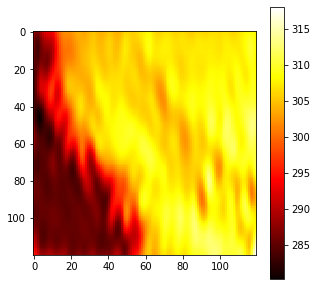

In [8]:
fig, ax = plt.subplots(figsize = (5,5))
test_map = ax.imshow(fin[215], cmap="hot", interpolation="none")
cbar = fig.colorbar(test_map, ax=ax)

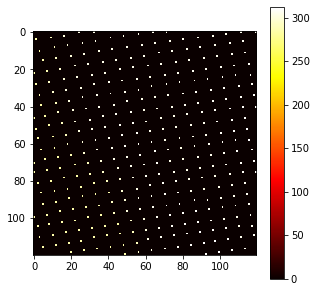

In [9]:
fig, ax = plt.subplots(figsize = (5,5))
test_map = ax.imshow(np.array(max_temp.iloc[215]).reshape(120, 120), cmap="hot", interpolation="none")
cbar = fig.colorbar(test_map, ax=ax)